# Use GPU (optional)

In [3]:
# make sure colab uses GPU
#' ' means CPU whereas '/device:G:0' means GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=bf8cafe9f89e59ccf1fdbe65e3c9ed17c42e7ee6d8b2269f9f532359ff3c1782
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.4 GB  | Proc size: 785.9 MB
GPU RAM Free: 11317MB | Used: 124MB | Util   1% | Total 11441MB


In [5]:
# !kill -9 -1

# Imports and Load Data

In [21]:
# Standard scientific Python imports
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns # for visualisation
import numpy as np

from numpy import mean
from numpy import std
from numpy import arange

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE

from statsmodels.stats.outliers_influence import variance_inflation_factor


# Default plotting parameters
font = {'size'   : 18}
plt.rc('font', **font)

In [22]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# Load training dataset
rep = "/content/drive/My Drive/Oxford/SML Group Practical/" # change to your drive location
y_train = pd.read_csv(rep + 'y_train.csv', index_col = 0, squeeze=True)
X_train = pd.read_csv(rep + 'X_train.csv', index_col = 0, header=[0, 1, 2]) #sets up header to be tuple
X_test = pd.read_csv(rep + 'X_test.csv', index_col = 0, header=[0, 1, 2])

# Create version with them together
Xy = pd.concat([X_train, y_train], axis = 1)

# Extract variable names (in the form of 'feature-statistics-number')
variable_names = X_train.keys().get_level_values(0).astype(str).values + ' - ' + X_train.keys().get_level_values(1).astype(str).values + ' - ' + X_train.keys().get_level_values(2).astype(str).values
print(variable_names[0:5,])

['chroma_cens - kurtosis - 01' 'chroma_cens - kurtosis - 02'
 'chroma_cens - kurtosis - 03' 'chroma_cens - kurtosis - 04'
 'chroma_cens - kurtosis - 05']


# Functions

The Export Function:

In [24]:
# Function to format the predictions in a dataframe and export to a csv file, to be uploaded on kaggle
def export_to_csv(y_hat, filename):
    df = pd.DataFrame({'Genre': y_hat})
    df.index.name = 'Id'
    df.to_csv(filename)

Define the function that assesses performance for each classifier, using three repeats of 4-fold CV:

In [25]:
def cv_clf(clf, X, y):
    cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=15)
    # evaluate model accuracy
    cv_results = cross_validate(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, return_train_score=True)
    ts_scores = cv_results['test_score']
    print('Mean Validation Accuracy: %.3f (%.3f)' % (mean(ts_scores), std(ts_scores)))

Define the grid search function for tuning parameters:

In [26]:
def grid_search(clf, X, y, par1, par2, val1, val2):
    # define grid
    grid = dict()
    grid[par1] = val1
    grid[par2] = val2
    # define search   
    cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=1)
    search = GridSearchCV(clf, grid, scoring='accuracy', cv=cv, n_jobs=-1)
    # perform the search
    results = search.fit(X, y)
    # summarize
    print('Mean Validation Accuracy: %.3f' % results.best_score_)
    print('Config: %s' % results.best_params_)

# Logistic Regression


Summary:
1. Projecting data on onto PCA/LDA coordinates does not improve results. 
2. No significant improvements by using different scalers.
3. No need to do polynomial input transformation, as it will certainly lead to overfitting.

Use SAGA algorithm (a variety of Stochastic Average Gradient method that also supports L1 penalty) to estimate parameters, since it supports all of L1, L2 and Elastic Net penalty. <br>Better test accuracy with L2 penalty. 

In [12]:
# Train-test split on scaled data
X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train , test_size=0.20 , random_state=15)

# Standardise data
scaler = StandardScaler() 
scaler.fit(X_tr)
X_tr_sd = scaler.transform(X_tr)
X_te_sd = scaler.transform(X_te)

0. All features used

In [ ]:
lr = linear_model.LogisticRegression(penalty = 'none', solver = 'saga', max_iter = 1000)
print("No Penalty:")
cv_clf(lr, X_tr_sd, y_tr)

print("With Penalty:")
val1=('l1','l2','elasticnet')
val2=(1e-06, 1e-05, 0.0001, 0.001, 0.01, arange(0, 1, 0.2))
grid_search(lr, X_tr_sd, y_tr, 'penalty', 'C', val1, val2)

No Penalty:
Mean Validation Accuracy: 0.540 (0.011)
With Penalty:
Mean Validation Accuracy: 0.577
Config: {'C': 0.01, 'penalty': 'l2'}


In [ ]:
# train the model on the full training set from train-test split 
lr = linear_model.LogisticRegression(penalty = 'l2', C = 0.01, solver = 'saga', max_iter = 1000)
lr.fit(X_tr_sd,y_tr)
lr.score(X_te_sd,y_te) 

0.5733333333333334

1. ANOVA

In [12]:
# ANOVA feature selection 
fs = SelectKBest(score_func=f_classif, k=300)
fs = fs.fit(X_tr_sd, y_tr)
X_tr_sel = fs.transform(X_tr_sd)
X_te_sel = fs.transform(X_te_sd)

In [13]:
lr = linear_model.LogisticRegression(penalty = 'none', solver = 'saga', max_iter = 1000)
print("No Penalty:")
cv_clf(lr, X_tr_sel, y_tr)

print("With Penalty:")
val1=('l1','l2','elasticnet')
val2=(1e-06, 1e-05, 0.0001, 0.001, 0.01, arange(0, 1, 0.2))
grid_search(lr, X_tr_sel, y_tr, 'penalty', 'C', val1, val2)

No Penalty:
Mean Validation Accuracy: 0.537 (0.011)
With Penalty:
Mean Validation Accuracy: 0.569
Config: {'C': 0.01, 'penalty': 'l2'}


In [14]:
# train the model on the full training set from train-test split 
lr = linear_model.LogisticRegression(penalty = 'l2', C = 0.01, solver = 'saga', max_iter = 1000)
lr.fit(X_tr_sel,y_tr)
lr.score(X_te_sel,y_te) 

0.5625

2. RFE

In [13]:
# RFE feature selection
rfe = RFE(estimator=LinearDiscriminantAnalysis(solver='eigen', store_covariance=True), n_features_to_select=300)
rfe = rfe.fit(X_tr_sd, y_tr)
X_tr_sel = rfe.transform(X_tr_sd)
X_te_sel = rfe.transform(X_te_sd)

In [14]:
lr = linear_model.LogisticRegression(penalty = 'none', solver = 'saga', max_iter = 1000)
print("No Penalty:")
cv_clf(lr, X_tr_sel, y_tr)

print("With Penalty:")
val1=('l1','l2','elasticnet')
val2=(1e-06, 1e-05, 0.0001, 0.001, 0.01, arange(0, 1, 0.2))
grid_search(lr, X_tr_sel, y_tr, 'penalty', 'C', val1, val2)

No Penalty:
Mean Validation Accuracy: 0.556 (0.011)
With Penalty:
Mean Validation Accuracy: 0.569
Config: {'C': 0.01, 'penalty': 'l2'}


In [15]:
# train the model on the full training set from train-test split 
lr = linear_model.LogisticRegression(penalty = 'l2', C = 0.01, solver = 'saga', max_iter = 1000)
lr.fit(X_tr_sel,y_tr)
lr.score(X_te_sel,y_te) 

0.5725

3. Remove Collinear Variables (with high VIF)

In [16]:
# remove all features wit VIF greater than a threshold (to keep around 300 data points)
vif_train = pd.DataFrame()
vif_train["VIF Factor"] = [variance_inflation_factor(X_tr_sd, i) for i in range(X_tr_sd.shape[1])]

In [17]:
index = vif_train["VIF Factor"] < 20 # choose 20 as the threshold
print(sum(index))
X_tr_sel = X_tr_sd[:, index] 
X_te_sel = X_te_sd[:, index] 

301


In [18]:
lr = linear_model.LogisticRegression(penalty = 'none', solver = 'saga', max_iter = 1000)
print("No Penalty:")
cv_clf(lr, X_tr_sel, y_tr)

print("With Penalty:")
val1=('l1','l2','elasticnet')
val2=(1e-06, 1e-05, 0.0001, 0.001, 0.01, arange(0, 1, 0.2))
grid_search(lr, X_tr_sel, y_tr, 'penalty', 'C', val1, val2)

No Penalty:
Mean Validation Accuracy: 0.509 (0.013)
With Penalty:
Mean Validation Accuracy: 0.555
Config: {'C': 0.01, 'penalty': 'l2'}


In [19]:
# train the model on the full training set from train-test split 
lr = linear_model.LogisticRegression(penalty = 'l2', C = 0.01, solver = 'saga', max_iter = 1000)
lr.fit(X_tr_sel,y_tr)
lr.score(X_te_sel,y_te) 

0.5358333333333334

### Project data on PCA/LDA components

In [ ]:
# Fit PCA projections on training data, obtain projections for both train and test
k = 10
PC = PCA(n_components = k)
PC.fit(X_tr_sd) 
ZPC_tr = PC.transform(X_tr_sd) 
ZPC_te = PC.transform(X_te_sd) 

# Fit LDA projections on training data, obtain projections for both train and test
LDA = LinearDiscriminantAnalysis(n_components = 7)
LDA.fit(X_tr_sd, y_tr)
ZLDA_tr = LDA.transform(X_tr_sd)
ZLDA_te = LDA.transform(X_te_sd)

In [ ]:
print("First", k, "PCs:")
val1=('l1','l2','elasticnet')
val2=(1e-06, 1e-05, 0.0001, 0.001, 0.01, arange(0, 1, 0.2))
grid_search(lr, ZPC_tr, y_tr, 'penalty', 'C', val1, val2)

print("LDA Components:")
val1=('l1','l2','elasticnet')
val2=(1e-06, 1e-05, 0.0001, 0.001, 0.01, arange(0, 1, 0.2))
grid_search(lr, ZLDA_tr, y_tr, 'penalty', 'C', val1, val2)

First 10 PCs:
Mean Validation Accuracy: 0.405
Config: {'C': 0.01, 'penalty': 'l2'}
LDA Components:
Mean Validation Accuracy: 0.708
Config: {'C': 0.01, 'penalty': 'l2'}


In [ ]:
# train the LDA-transformed model on the full training set from train-test split 
lr = linear_model.LogisticRegression(penalty = 'l2', C = 0.01, solver = 'saga', max_iter = 1000)
lr.fit(ZLDA_tr,y_tr)
lr.score(ZLDA_te,y_te) 

0.5491666666666667

### Experiment with Other Scalers

Tried MinMaxScaler and QuantileTransformer. Overall, quantile transform to normal slightly improves the result.

In [ ]:
# Train-test split
X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train, test_size = 0.20 , random_state=15)

# Normalise data - suffer from outliers
scaler2 = MinMaxScaler()
scaler2.fit(X_tr)
X_tr_nr = scaler2.transform(X_tr)
X_te_nr = scaler2.transform(X_te)

# Quantile-transform to uniform - robust to outliers
scaler3 = QuantileTransformer(output_distribution='uniform')
scaler3.fit(X_tr)
X_tr_qu = scaler3.transform(X_tr)
X_te_qu = scaler3.transform(X_te)

# Quantile-transform to normal - robust to outliers
scaler4 = QuantileTransformer(output_distribution='normal')
scaler4.fit(X_tr)
X_tr_qn = scaler4.transform(X_tr)
X_te_qn = scaler4.transform(X_te)

1. Grid search and fit on test for Normalised data:

In [ ]:
# Grid search
val1=('l1','l2','elasticnet')
val2=(1e-06, 1e-05, 0.0001, 0.001, 0.01, arange(0, 1, 0.2))
grid_search(lr, X_tr_nr, y_tr, 'penalty', 'C', val1, val2)

Mean Validation Accuracy: 0.493
Config: {'C': 0.01, 'penalty': 'l2'}


In [ ]:
# validation accuracy
lr = linear_model.LogisticRegression(penalty='l2', solver = 'saga', C = 0.01, max_iter = 1000)
lr.fit(X_tr_nr,y_tr)
lr.score(X_te_nr,y_te)

0.4741666666666667

2. Grid search and fit on test for Uniform-Scaled data:

In [ ]:
# Grid search
val1=('l1','l2','elasticnet')
val2=(1e-06, 1e-05, 0.0001, 0.001, 0.01, arange(0, 1, 0.2))
grid_search(lr, X_tr_qu, y_tr, 'penalty', 'C', val1, val2)

Mean Validation Accuracy: 0.551
Config: {'C': 0.01, 'penalty': 'l2'}


In [ ]:
# validation accuracy
lr = linear_model.LogisticRegression(penalty='l2', solver = 'saga', C = 0.01, max_iter = 1000)
lr.fit(X_tr_qu,y_tr)
lr.score(X_te_qu,y_te)

0.5366666666666666

3. Grid search and fit on test for Normal-Scaled data:

In [ ]:
# Grid search
val1=('l1','l2','elasticnet')
val2=(1e-06, 1e-05, 0.0001, 0.001, 0.01, arange(0, 1, 0.2))
grid_search(lr, X_tr_qn, y_tr, 'penalty', 'C', val1, val2)

Mean Validation Accuracy: 0.575
Config: {'C': 0.01, 'penalty': 'l2'}


In [ ]:
# validation accuracy
lr = linear_model.LogisticRegression(penalty='l2', solver = 'saga', C = 0.01, max_iter = 1000)
lr.fit(X_tr_qn,y_tr)
lr.score(X_te_qn,y_te)

0.5725

Fit the model on the full training data:

In [32]:
# StandardScalar
scaler = StandardScaler() 
scaler.fit(X_train)
X_train_sd = scaler.transform(X_train)
X_test_sd = scaler.transform(X_test)

LR = linear_model.LogisticRegression(penalty='l2', solver = 'saga', C = 0.01, max_iter = 1000)
LR.fit(X_train_sd, y_train)
y_hat = LR.predict(X_test_sd)

# Export to CSV file 
# export_to_csv(y_hat,'Predictions_LR_final.csv')

# from google.colab import files
# files.download('Predictions_LR_final.csv')

# Variable Importance (LR)

Model: LR with L2 penality and C = 0.01.

For linear classifiers, rank the variables by the mean of the coefficients b_{kj} across all k.

Comment: The feature mfcc and the statistics min appear most frequently in the top 10 variables, so they can be view as "important".

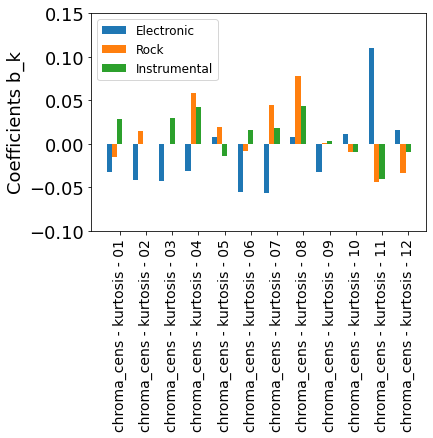

In [30]:
# Visualise the coefficients b_{kj} for k=0..3, j=0..12
width = 0.2
plt.figure()
for k in np.arange(3):    
    plt.bar(np.arange(0,12)+width*k,LR.coef_[k,0:12], tick_label=variable_names[0:12], width=width)
    plt.xticks(fontsize=14, rotation='vertical')
    plt.ylim([-0.1, 0.15])
    plt.ylabel('Coefficients b_k')    
plt.legend(['Electronic', 'Rock', 'Instrumental'], loc = 2, prop={'size': 12});

                              Variables  Coefficients
275                     mfcc - max - 04      0.167851
372                     mfcc - std - 01      0.140761
373                     mfcc - std - 02      0.103703
336                     mfcc - min - 05      0.100125
375                     mfcc - std - 04      0.095235
352                    mfcc - skew - 01      0.095184
515                      zcr - min - 01      0.093676
377                     mfcc - std - 06      0.093628
357                    mfcc - skew - 06      0.089466
405       spectral_bandwidth - std - 01      0.089327
292                    mfcc - mean - 01      0.088989
397                    rmse - skew - 01      0.087661
448       spectral_contrast - skew - 01      0.086947
341                     mfcc - min - 10      0.086203
399  spectral_bandwidth - kurtosis - 01      0.084911
272                     mfcc - max - 01      0.084575
312                  mfcc - median - 01      0.084467
398                     rmse

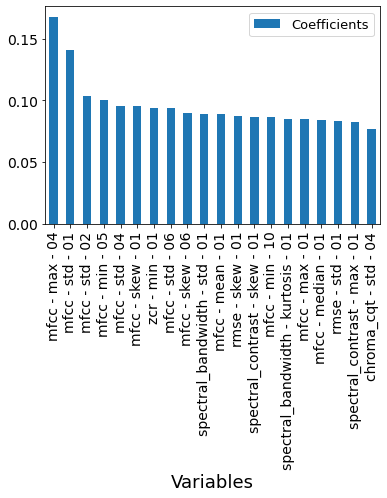

In [34]:
# get importance - the mean of the coefficients b_{kj} across k classes
importance = np.abs(LR.coef_).mean(axis=0)   
d = {'Variables': variable_names, 'Coefficients': importance}
df = pd.DataFrame(data=d)
# reorder the coefficients by their absolute values
df = df.iloc[(-df['Coefficients']).argsort()]
print(df.head(20))
df_new = df.head(20)
df_new.plot.bar(x='Variables', y='Coefficients', fontsize=14, rot='vertical')
plt.legend(prop={'size': 13})
plt.show()

# Compare LDA and Logistic Regression: <br>
Both are linear models and give similar test accuracy. <br>
But they are different in many aspects: <br>
- LDA assumes a normal density function for each class and identical within-group covariance matrices; LR does not assume any of these, thus it is more flexible<br>
- LDA: The groups should have similar number of data points; LR: The groups may have quite different number of data points
- LDA: Quite sensitive to outliers; LR: Not so sensitive to outliers
<br>